# Progseq

In their nature paper Cell simulation as cell segmentation the authors published a method called Proseg (probabilistic segmentation), to rapidly infer morphologically plausible cell boundaries. Their benchmarking pipeline could be used for similar pourpose as we intend. Here we try to recreate the pipelines. The original code is provided in julia here https://github.com/dcjones/SpuriousCoexpression.jl/tree/main.
This script aims to reproduce the score and obtain it for various methods based on the Visium post Xenium dataset.
We will use again dataset on lung cancer tissue

use the tmp_enact_analysis environment

"Secondly, we load another segmentation: 
To produce a relative spurious coexpression distribution, we computed the conditional coexpression for each method and each pair of spuriously coexpressed genes, and then normalized (divided) by the rate observed under nuclear segmentation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata

In [2]:
path_nuclei_coexpr = "/home/degottardiraphael/MasterThesis/Benchmarking pipeline/Scores/Spurious Coexpression/coexpr_matrix_nuc_res.npy"
path_spurious_mask = "/home/degottardiraphael/MasterThesis/Benchmarking pipeline/Scores/Spurious Coexpression/spurious_mask.npy"
cells_adata_path = "/srv/gstore/projects/p1001/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/binned_outputs/square_008um/filtered_feature_bc_matrix.h5"



In [3]:
# Loading Anndata object
adata_cells = sc.read_10x_h5(cells_adata_path)
adata_cells

/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/misc/ngseq12/miniforge3/envs/tmp_enact_analysis/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 411242 × 18085
    var: 'gene_ids', 'feature_types', 'genome'

In [4]:
sc.pp.calculate_qc_metrics(adata_cells, inplace=True)
print("Quality control metrics for cells:")
print(adata_cells.obs[['total_counts', 'n_genes_by_counts']].describe())

Quality control metrics for cells:
        total_counts  n_genes_by_counts
count  411242.000000      411242.000000
mean       70.439392          61.094574
std        66.170616          56.742862
min         0.000000           0.000000
25%        18.000000          17.000000
50%        51.000000          43.000000
75%       106.000000          91.000000
max      1178.000000         894.000000


In [5]:

total_counts_cells = np.array(adata_cells.X.sum(axis=1)).flatten()
cell_mask_50 = total_counts_cells >= 50
filtered_ids = adata_cells.obs_names[cell_mask_50]
# Use mean_counts from AnnData var to get indices of top 1000 genes
mean_counts = adata_cells.var["mean_counts"].values
top_1000_idx = np.argsort(mean_counts)[-1000:]
# only keep the first 10000 cells for memory efficiency
adata_cells_ready = adata_cells[filtered_ids[:10000], top_1000_idx].copy()

print(f"Cells remaining after filtering for >50 transcripts: {len(filtered_ids)}")
adata_cells_ready

Cells remaining after filtering for >50 transcripts: 208293


AnnData object with n_obs × n_vars = 10000 × 1000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [6]:

# Check for floating point precision issues in multinomial_downsample
def safe_multinomial_downsample(cdata):
    X = cdata.X.toarray() 
    X_ds = np.zeros_like(X, dtype=int)
    for i in range(X.shape[0]):
        counts = X[i]
        total = counts.sum()
        if total > 1:
            probs = counts / total
            # Normalize to sum to 1.0
            if probs.sum() > 0:
                probs = probs.astype(np.float64)  # Cast to 64-bit float
                probs = probs / probs.sum()
                X_ds[i] = np.random.multinomial(50, probs, size=1).flatten()
            else:
                print(f"Warning: Row {i} has zero total counts, skipping downsampling.")
        else:
            print(f"Warning: Row {i} has total counts {counts.sum()}<= 1, skipping downsampling.")
    return X_ds

cell_X_ds = safe_multinomial_downsample(adata_cells_ready)

# Create new AnnData objects with downsampled counts
adata_cells_resampled = anndata.AnnData(cell_X_ds, obs=adata_cells_ready.obs.copy(), var=adata_cells_ready.var.copy())

In [7]:
print("Binarizing expression matrix (cell_X_ds > 0)...")
expr = (cell_X_ds > 0).astype(int)

print("Calculating coexpression matrix using matrix multiplication...")
coexpr_matrix = (expr.T @ expr) / np.sum(expr, axis=0)

# Zero out diagonal to ignore self-coexpression
coexpr_no_diag = coexpr_matrix.copy()
np.fill_diagonal(coexpr_no_diag, 0)

# Find the indices of the top N coexpressed gene pairs
N = 10
flat_indices = np.argpartition(coexpr_no_diag.flatten(), -N)[-N:]
row_idx, col_idx = np.unravel_index(flat_indices, coexpr_no_diag.shape)

# Get gene names
gene_names = adata_cells.var_names

# List the most coexpressed gene pairs and their counts
top_pairs = []
for i, j in zip(row_idx, col_idx):
    top_pairs.append((gene_names[i], gene_names[j], coexpr_no_diag[i, j]))

# Sort by coexpression count descending
top_pairs = sorted(top_pairs, key=lambda x: -x[2])

for g1, g2, count in top_pairs:
    print(f"{g1} - {g2}: {count}")

Binarizing expression matrix (cell_X_ds > 0)...
Calculating coexpression matrix using matrix multiplication...
NOTCH2 - CHIA: 0.9455782312925171
NOTCH2 - CCDC18: 0.9378238341968912
NOTCH2 - C1orf141: 0.9326424870466321
PDZK1 - NRAS: 0.9046728971962616
PDZK1 - CYB561D1: 0.9018691588785047
PDZK1 - WARS2: 0.8855421686746988
NOTCH2 - SPOCD1: 0.8646616541353384
PDZK1 - MAB21L3: 0.8443496801705757
NOTCH2 - TTF2: 0.8439849624060151
PDZK1 - WDR63: 0.8344827586206897


In [8]:
coexpr_matrix_nuc_res = np.load(path_nuclei_coexpr)
print("Nucleus coexpression matrix shape:", coexpr_matrix_nuc_res.shape)

Nucleus coexpression matrix shape: (1000, 1000)


In [9]:
# Avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    rel_increase_res = coexpr_no_diag / np.where(coexpr_matrix_nuc_res > 0, coexpr_matrix_nuc_res, 1)

In [10]:
spurious_mask = np.load(path_spurious_mask)
print("Spurious mask shape:", spurious_mask.shape)

Spurious mask shape: (1000, 1000)


In [11]:
# Use the spurious_mask to extract relative coexpression values from rel_increase_res
spurious_rel_coexpr_values = rel_increase_res[spurious_mask]
print(f"Extracted {spurious_rel_coexpr_values.size} spurious relative coexpression values.")

Extracted 236020 spurious relative coexpression values.


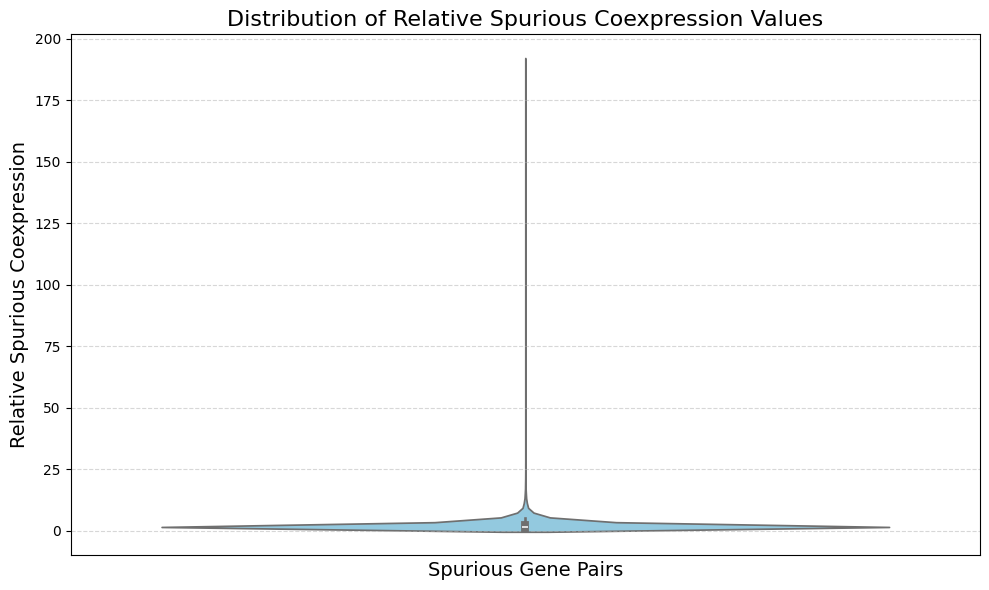

In [12]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(data=spurious_rel_coexpr_values, inner="box", color="skyblue")
plt.title("Distribution of Relative Spurious Coexpression Values", fontsize=16)
plt.ylabel("Relative Spurious Coexpression", fontsize=14)
plt.xlabel("Spurious Gene Pairs", fontsize=14)
plt.xticks([])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [13]:
print("Summary statistics for spurious relative coexpression values:")
print(f"Count: {spurious_rel_coexpr_values.size}")
print(f"Mean: {np.mean(spurious_rel_coexpr_values):.4f}")
print(f"Median: {np.median(spurious_rel_coexpr_values):.4f}")
print(f"Standard deviation: {np.std(spurious_rel_coexpr_values):.4f}")
print(f"Min: {np.min(spurious_rel_coexpr_values):.4f}")
print(f"Max: {np.max(spurious_rel_coexpr_values):.4f}")

Summary statistics for spurious relative coexpression values:
Count: 236020
Mean: 1.9732
Median: 1.5140
Standard deviation: 2.0360
Min: 0.0000
Max: 191.8311


In [14]:
import pandas as pd

csv_path = "/home/degottardiraphael/MasterThesis/Benchmarking pipeline/Scores/Spurious Coexpression/spurious_rel_coexpr.csv"
df_spurious = pd.read_csv(csv_path)
df_spurious["8x8"] = spurious_rel_coexpr_values
df_spurious.to_csv(csv_path, index=False)
print("Added '8x8' column to CSV and saved.")

Added '8x8' column to CSV and saved.


In [15]:
# Find pairs with >50% increase in coexpression in cells vs nuclei
spurious_mask15 = rel_increase_res > 1.5

# Get indices of such pairs
spurious_row, spurious_col = np.where(spurious_mask)

# List the pairs 
spurious_pairs = []
for i, j in zip(spurious_row, spurious_col):
    spurious_pairs.append((gene_names[i], gene_names[j], coexpr_no_diag[i, j], coexpr_matrix_nuc_res[i, j], rel_increase_res[i, j]))

print(f"Number of potentially spurious pairs: {len(spurious_pairs)}")
# Show top 10 by relative increase
spurious_pairs_sorted = sorted(spurious_pairs, key=lambda x: -x[4])
for g1, g2, cell_val, nuc_val, rel_inc in spurious_pairs_sorted[:10]:
    print(f"{g1} - {g2}: cell={cell_val}, nuclei={nuc_val}, rel_increase={rel_inc:.2f}")

Number of potentially spurious pairs: 236020
CTTNBP2NL - NBPF20: cell=0.04315659679408138, nuclei=0.0002249718785151856, rel_increase=191.83
NOTCH2 - ELAVL4: cell=0.783625730994152, nuclei=0.00625, rel_increase=125.38
NOTCH2 - CCDC18: cell=0.9378238341968912, nuclei=0.00823045267489712, rel_increase=113.95
DNAJC6 - PDZK1: cell=0.01590005678591709, nuclei=0.00017041581458759374, rel_increase=93.30
NOTCH2 - PIGK: cell=0.35909090909090907, nuclei=0.004201680672268907, rel_increase=85.46
GFI1 - FCGR1B: cell=0.028565002249212774, nuclei=0.00033534540576794097, rel_increase=85.18
NOTCH2 - CHIA: cell=0.9455782312925171, nuclei=0.011396011396011397, rel_increase=82.97
TRIM45 - SLC16A4: cell=0.15833333333333333, nuclei=0.0022371364653243847, rel_increase=70.77
NOTCH2 - TIE1: cell=0.6474358974358975, nuclei=0.00980392156862745, rel_increase=66.04
DNAJC6 - NBPF20: cell=0.014385532264693794, nuclei=0.0002249718785151856, rel_increase=63.94
